In [1]:
import random
import numpy as np

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import preprocessing
import nltk
import csv

In [2]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yayou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yayou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

In [6]:
with open("random_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    for row in random_predictions:
        csv_out.writerow(row)

In [7]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

In [8]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

In [9]:
# computes the TFIDF features from the abstract

corpus = [element[5] for element in node_info]
vectorizer = TfidfVectorizer(stop_words="english")
features_TFIDF = vectorizer.fit_transform(corpus)

In [10]:
def compute_features(citation_set, IDs, node_info, stpwds, features_TFIDF):
    overlap_title = []
    temp_diff = []
    comm_auth = []
    dist = []

    counter = 0
    for i in range(len(citation_set)):
        source = citation_set[i][0]
        target = citation_set[i][1]

        index_source = IDs.index(source)
        index_target = IDs.index(target)

        source_info = [element for element in node_info if element[0]==source][0]
        target_info = [element for element in node_info if element[0]==target][0]

        # convert to lowercase and tokenize
        source_title = source_info[2].lower().split(" ")
        # remove stopwords
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]

        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]

        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")

        overlap_title.append(
            len(set(source_title).intersection(set(target_title)))
        )
        temp_diff.append(
            int(source_info[1]) - int(target_info[1])
        )
        comm_auth.append(
            len(set(source_auth).intersection(set(target_auth)))
        )
        dist.append(
            np.linalg.norm(
                (features_TFIDF[IDs.index(source)]-features_TFIDF[IDs.index(target)]
                ).toarray()
            )
        )

        counter += 1
        if counter % 5000 == True:
            print(counter, "training examples processsed")
            
    overlap_title = np.array(overlap_title)
    overlap_title = preprocessing.scale(overlap_title)
    temp_diff = np.array(temp_diff)
    temp_diff = preprocessing.scale(temp_diff)
    comm_auth = np.array(comm_auth)
    comm_auth = preprocessing.scale(comm_auth)
    dist = np.array(dist)
        
    features = np.array([overlap_title, temp_diff, comm_auth, dist])
        
    return np.array([[features[0][j], 
                      features[1][j], 
                      features[2][j], 
                      features[3][j]] for j in range(features.shape[1])])
            
        

##### generates training features and labels from a reduced training sample

In [11]:
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
training_set_reduced = [training_set[i] for i in to_keep]

training_features = compute_features(training_set_reduced, IDs, node_info, stpwds, features_TFIDF)

labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

1 training examples processsed
5001 training examples processsed
10001 training examples processsed
15001 training examples processsed
20001 training examples processsed
25001 training examples processsed
30001 training examples processsed


C:\Users\yayou\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


##### generates testing features and labels from a reduced testing sample from the main training sample

In [12]:
to_keep2 = random.sample(range(len(training_set)),
                         k=int(round(len(training_set)*0.05)))
training_set_reduced2 = [training_set[i] for i in to_keep2]

testing_features = compute_features(training_set_reduced2, 
                                    IDs, 
                                    node_info, 
                                    stpwds, 
                                    features_TFIDF)

labels_test = [int(element[2]) for element in training_set_reduced2]
labels_test = list(labels_test)
labels_test_array = np.array(labels_test)

1 training examples processsed
5001 training examples processsed
10001 training examples processsed
15001 training examples processsed
20001 training examples processsed
25001 training examples processsed
30001 training examples processsed


C:\Users\yayou\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### using a SVC

In [13]:
classifier = svm.LinearSVC()
classifier.fit(training_features, labels_array)

predictions_SVM = classifier.predict(testing_features)

print('loss: ', 1-((labels_test_array - predictions_SVM)**2).mean())

loss:  0.8303223290876007


### using a NN

In [17]:
from keras import models
from keras.layers import Dense, Dropout, Flatten

# pip install livelossplot 
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

BATCH_SIZE = 1000
EPOCHS = 100

C:\Users\yayou\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


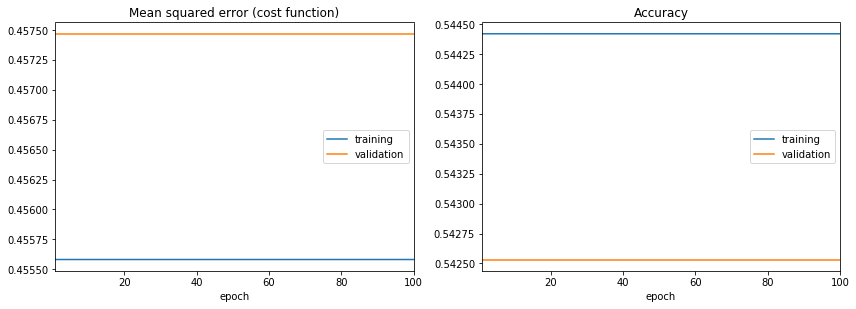

Mean squared error (cost function):
training   (min:    0.456, max:    0.456, cur:    0.456)
validation (min:    0.457, max:    0.457, cur:    0.457)

Accuracy:
training   (min:    0.544, max:    0.544, cur:    0.544)
validation (min:    0.543, max:    0.543, cur:    0.543)
Test loss: 0.457466857283649
Test accuracy: 0.5425331426931103


In [18]:
# defines the model

NN = models.Sequential()
NN.add(Dense(5, activation='relu', input_shape=(4,)))
NN.add(Dropout(0.05))
NN.add(Dense(5, activation='relu'))
NN.add(Dropout(0.25))
NN.add(Dense(1, activation='softmax'))

NN.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

# trains and plots the evolution of the loss
NN.fit(training_features, labels_array,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[plot_losses],
          verbose=1,
          validation_data=(testing_features, labels_test_array))

score = NN.evaluate(testing_features, labels_test_array, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Clustering based on Abstract TFIDF features 

In [14]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [36]:
from time import clock
from scipy.sparse.linalg import norm

t1 = clock()
np.linalg.norm((features_TFIDF[0]-features_TFIDF[6]).toarray())
t2 = clock()
t3 = clock()
norm(features_TFIDF[0]-features_TFIDF[6])
t4 = clock()
(t2 - t1), (t4-t3)

(0.0010130230423328612, 0.0011125805248184406)

### Graph part

In [15]:
import networkx as nx

In [16]:
def compute_graph_authors(citation_set, IDs, node_info, directed_or_not='y'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    counter = 0
    for i in range(len(citation_set)):
        source = citation_set[i][0]
        target = citation_set[i][1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)

        source_info = [element for element in node_info if element[0]==source][0]
        target_info = [element for element in node_info if element[0]==target][0]

        '''
        source_title = source_info[2].lower().split(" ")
        
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]

        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]
        '''

        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")
        
        if citation_set[i][2] == '1':
            for auth1 in source_auth:
                for auth2 in target_auth:
                    G.add_edge(auth1, auth2)
        else:
            for auth1 in source_auth:
                for auth2 in target_auth:
                    G.add_node(auth1)
                    G.add_node(auth2)
                
        counter += 1
        if counter % 5000 == True:
            print(counter, "training examples processsed")
        
    return G

In [17]:
G = compute_graph_authors(training_set_reduced,IDs,node_info)

1 training examples processsed
5001 training examples processsed
10001 training examples processsed
15001 training examples processsed
20001 training examples processsed
25001 training examples processsed
30001 training examples processsed


In [22]:
def compute_graph_articles_citation(citation_set, directed_or_not='y'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    counter = 0
    for i in range(len(citation_set)):
        source = citation_set[i][0]
        target = citation_set[i][1]
        
        '''
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_info = [element for element in node_info if element[0]==source][0]
        target_info = [element for element in node_info if element[0]==target][0]

        
        source_title = source_info[2].lower().split(" ")
        
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]

        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]
        
        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")
        '''
        
        if citation_set[i][2] == '1':
                    G.add_edge(source, target)
        else:
                    G.add_node(source)
                    G.add_node(target)
                
        counter += 1
        if counter % 5000 == True:
            print(counter, "training examples processsed")
        
    return G

In [24]:
from time import clock
t1 = clock()
G_bis = compute_graph_articles_citation(training_set_reduced)
t2 = clock()
t2 - t1

1 training examples processsed
5001 training examples processsed
10001 training examples processsed
15001 training examples processsed
20001 training examples processsed
25001 training examples processsed
30001 training examples processsed


0.1153569626931045

In [27]:
G_bis.adjacency

<bound method Graph.adjacency of <networkx.classes.digraph.DiGraph object at 0x000001AE8C368780>>
